In [1]:
freq = 15

In [2]:
paciente='paciente2'

In [3]:
import codigo
from codigo import utils
from codigo import model_LSTM
from codigo import model_utils
from cg_ega.cg_ega import CG_EGA

In [4]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [7]:
len(array_Xtest)

1742

In [8]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [9]:
len(array_Ytest)

1742

In [10]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Pruebas Vanilla LSTM con dropout

In [11]:
model = keras.models.load_model('modelos/'+paciente+'/vanilla_dropout_balanceado.h5')

# Predicción de todo el conjunto de pruebas generales

In [12]:
len(array_Ytest)

1742

55/55 [==============================] - 1s 5ms/step


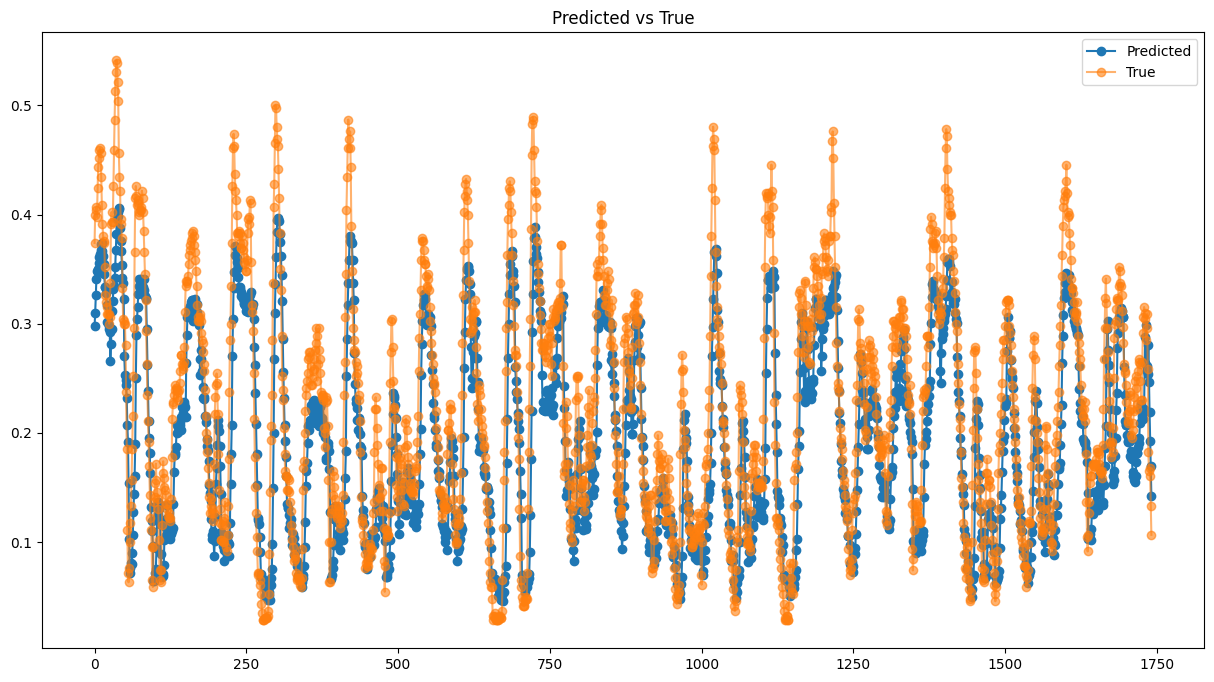

In [13]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [14]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.045444156949938225,
 'mse': 0.0605121471413797,
 'rmse': 0.0036617199516599873}

In [15]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        176.932678
1        182.360901
2        189.988235
3        196.740875
4        200.306168
...             ...
1737     153.423615
1738     140.655136
1739     128.409409
1740     118.183243
1741     105.165771

[1742 rows x 1 columns]

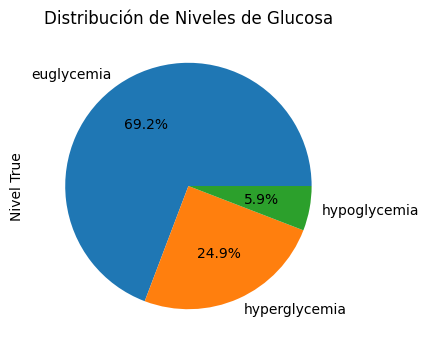

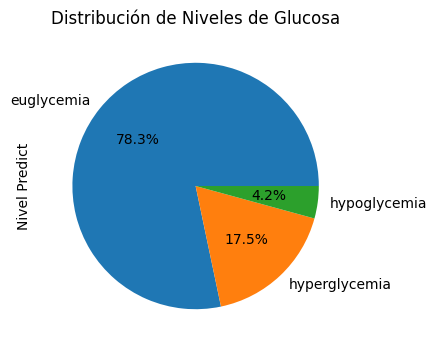

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               212.0  hyperglycemia             176.932678     euglycemia
1               224.0  hyperglycemia             182.360901  hyperglycemia
2               226.0  hyperglycemia             189.988235  hyperglycemia
3               227.0  hyperglycemia             196.740875  hyperglycemia
4               223.0  hyperglycemia             200.306168  hyperglycemia

In [16]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


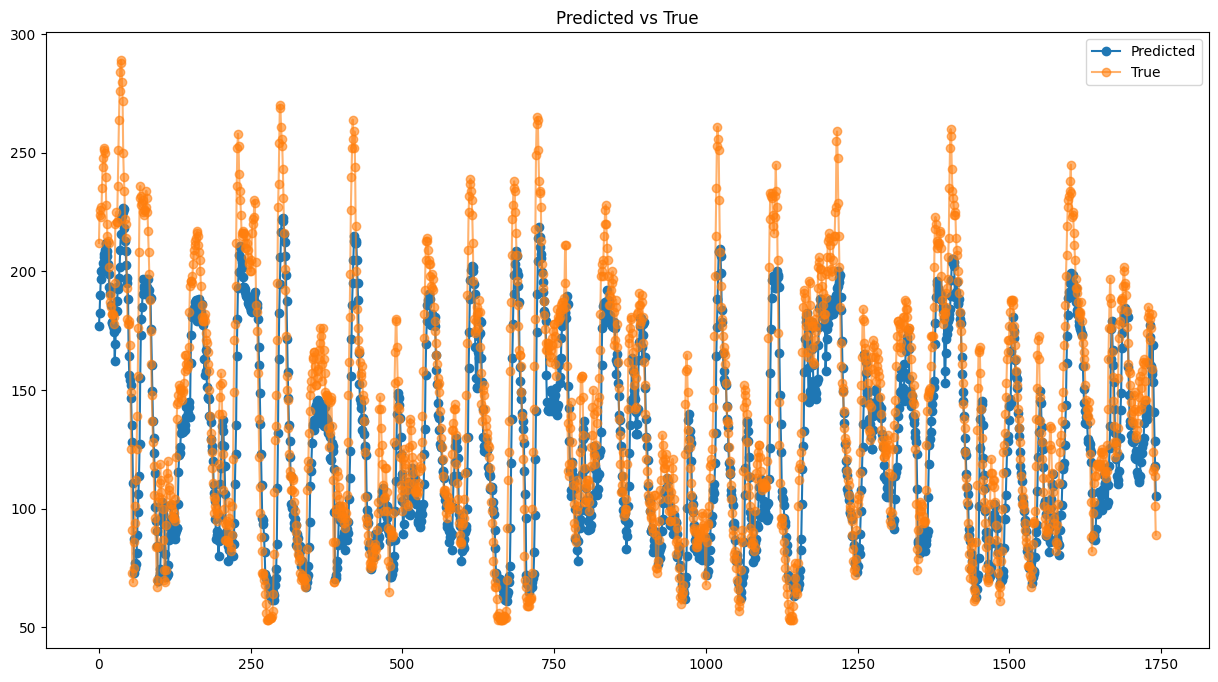

{'mae': 20.904311681076617,
 'mse': 27.835587161651805,
 'rmse': 774.8199126339148}

In [17]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [18]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0             212.0
1             224.0
2             226.0
3             227.0
4             223.0
...             ...
1737          116.0
1738          117.0
1739          114.0
1740          101.0
1741           89.0

[1742 rows x 1 columns]

In [19]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   212.0  176.932678
2023-01-01 00:15:00   224.0  182.360901
2023-01-01 00:30:00   226.0  189.988235
2023-01-01 00:45:00   227.0  196.740875
2023-01-01 01:00:00   223.0  200.306168
...                     ...         ...
2023-01-19 02:15:00   116.0  153.423615
2023-01-19 02:30:00   117.0  140.655136
2023-01-19 02:45:00   114.0  128.409409
2023-01-19 03:00:00   101.0  118.183243
2023-01-19 03:15:00    89.0  105.165771

[1742 rows x 2 columns]

AP, BE, EP: (0.9753015508328546, 0.004595060310166571, 0.020103388856978748)


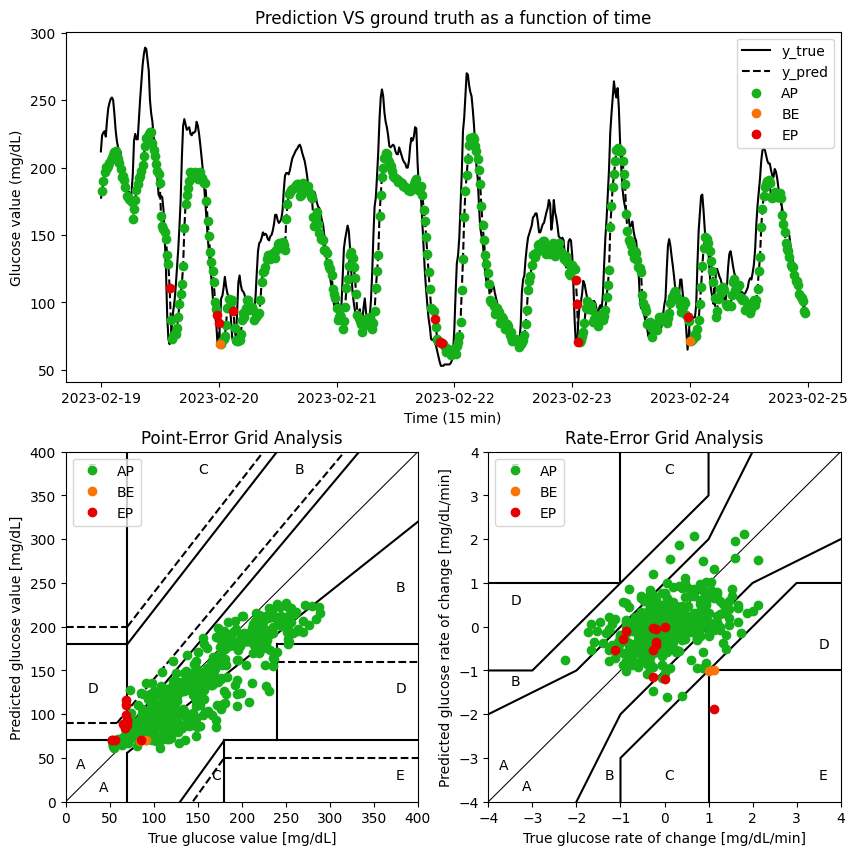

In [20]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [21]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0    2023-02-19 00:00:00   212.0  176.932678       NaN       NaN    NaN   NaN   
1    2023-02-19 00:15:00   224.0  182.360901  0.800000  0.361882     AP     A   
2    2023-02-19 00:30:00   226.0  189.988235  0.133333  0.508489     AP     A   
3    2023-02-19 00:45:00   227.0  196.740875  0.066667  0.450176     AP     A   
4    2023-02-19 01:00:00   223.0  200.306168 -0.266667  0.237686     AP     A   
...                  ...     ...         ...       ...       ...    ...   ...   
1737 2023-03-09 02:15:00   116.0  153.423615 -0.533333 -1.039042     AP     B   
1738 2023-03-09 02:30:00   117.0  140.655136  0.066667 -0.851232     AP     B   
1739 2023-03-09 02:45:00   114.0  128.409409 -0.200000 -0.816382     AP     A   
1740 2023-03-09 03:00:00   101.0  118.183243 -0.866667 -0.681744     AP     A   
1741 2023-03-09 03:15:00    89.0  105.165771 -0.800000 -0.867831     AP     A   

     R_EGA  
0      NaN  
1        A  
2        A  
3        A  
4        A  
...    ...  
1737     A  
1738     A  
1739     A  
1740     A  
1741     A  

[1742 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [22]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [23]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 73ms/step


Glucose level Predict  Glucose level True
0                0.29768            0.373913
1                0.30948            0.400000

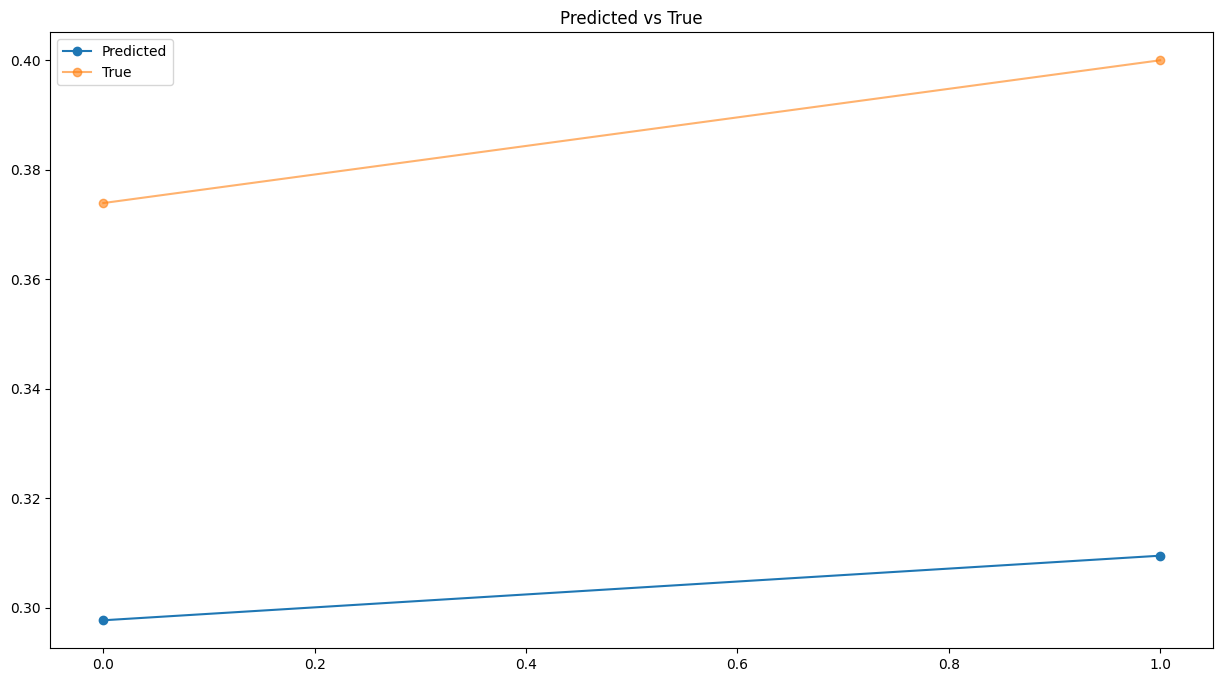

{'mae': 0.08337658034718556,
 'mse': 0.083682016445021,
 'rmse': 0.007002679876304766}

In [24]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [25]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             176.932663               212.0
1             182.360886               224.0

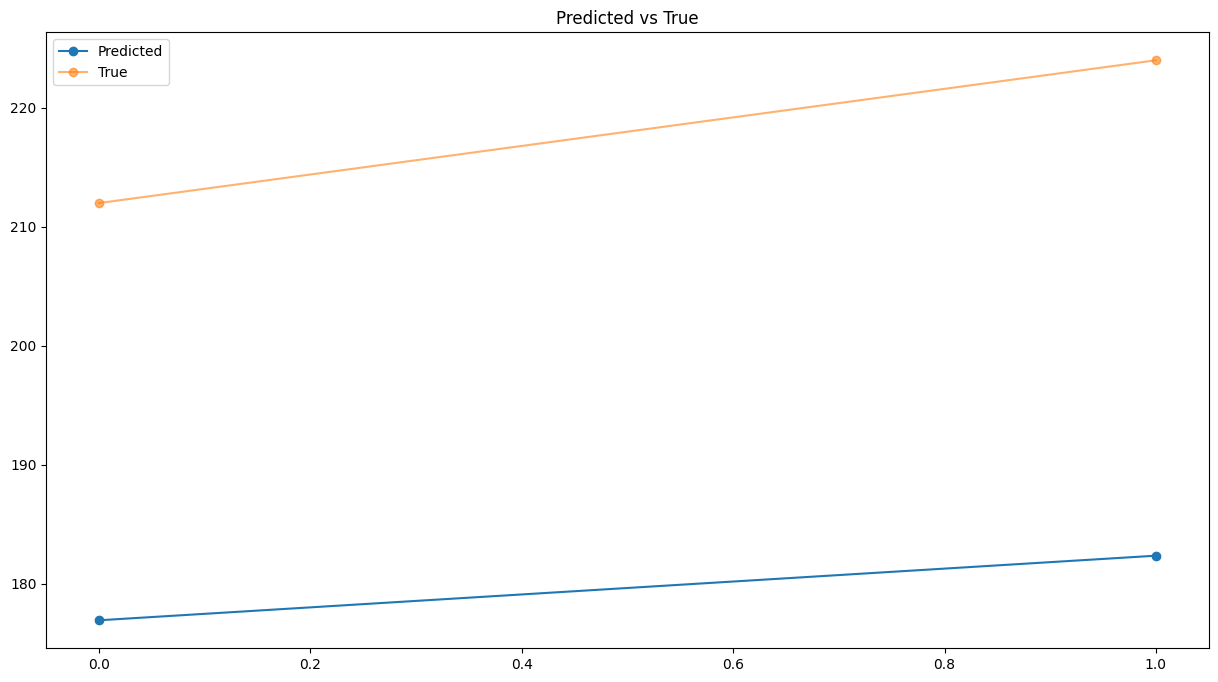

{'mae': 38.35322570800781,
 'mse': 38.49372658724208,
 'rmse': 1481.7669865733478}

In [26]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Vanilla LSTM sin dropout

In [27]:
model = keras.models.load_model('modelos/'+paciente+'/vanilla_NO_dropout_balanceado.h5')

# Predicción de todo el conjunto de pruebas generales

In [28]:
len(array_Ytest)

1742

55/55 [==============================] - 1s 10ms/step


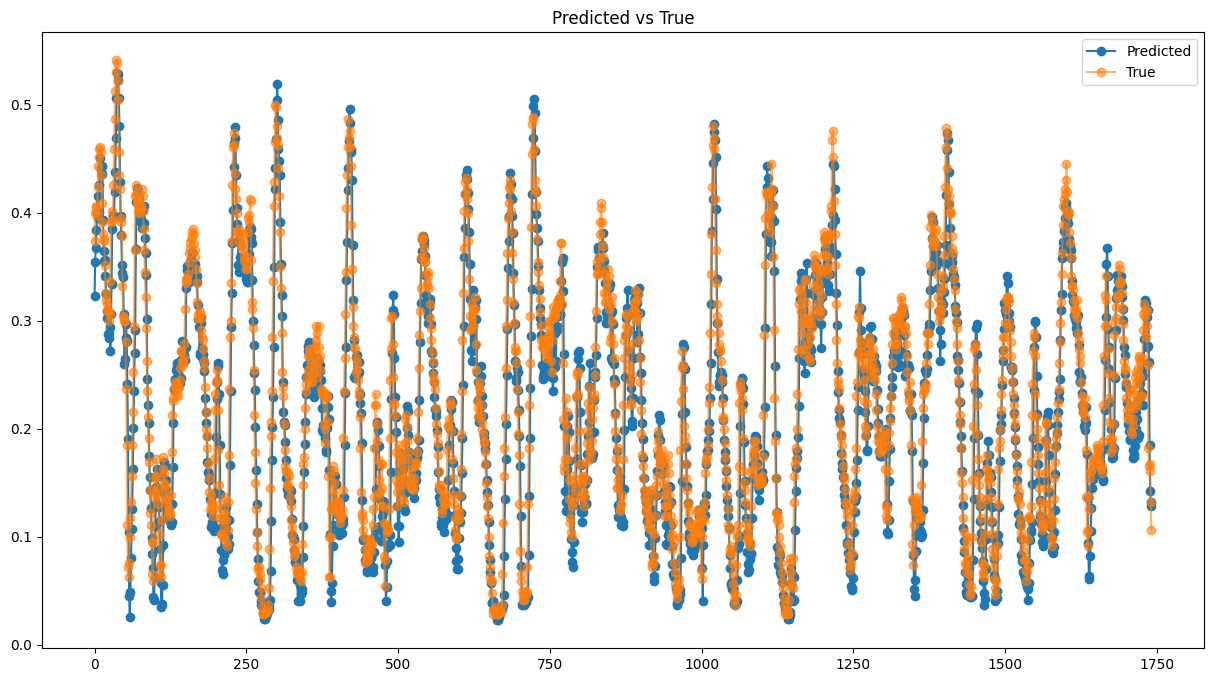

In [29]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [30]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.02766530784724416,
 'mse': 0.037921605629287085,
 'rmse': 0.0014380481735031777}

In [31]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        188.619431
1        202.950089
2        209.007614
3        216.782211
4        224.132401
...             ...
1737     160.556122
1738     125.244652
1739     105.473351
1740     100.754814
1741      99.194313

[1742 rows x 1 columns]

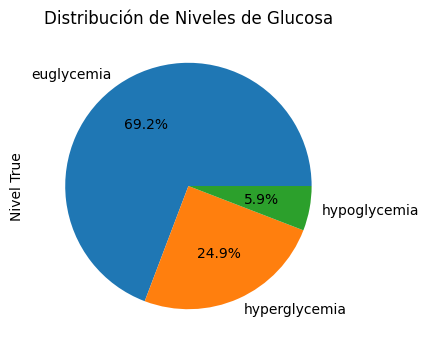

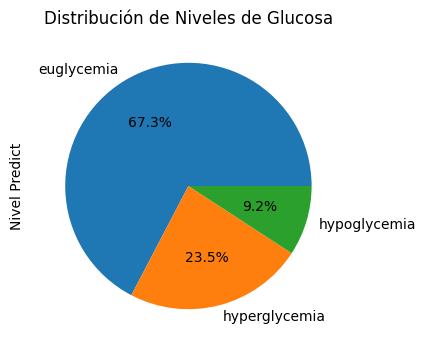

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               212.0  hyperglycemia             188.619431  hyperglycemia
1               224.0  hyperglycemia             202.950089  hyperglycemia
2               226.0  hyperglycemia             209.007614  hyperglycemia
3               227.0  hyperglycemia             216.782211  hyperglycemia
4               223.0  hyperglycemia             224.132401  hyperglycemia

In [32]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


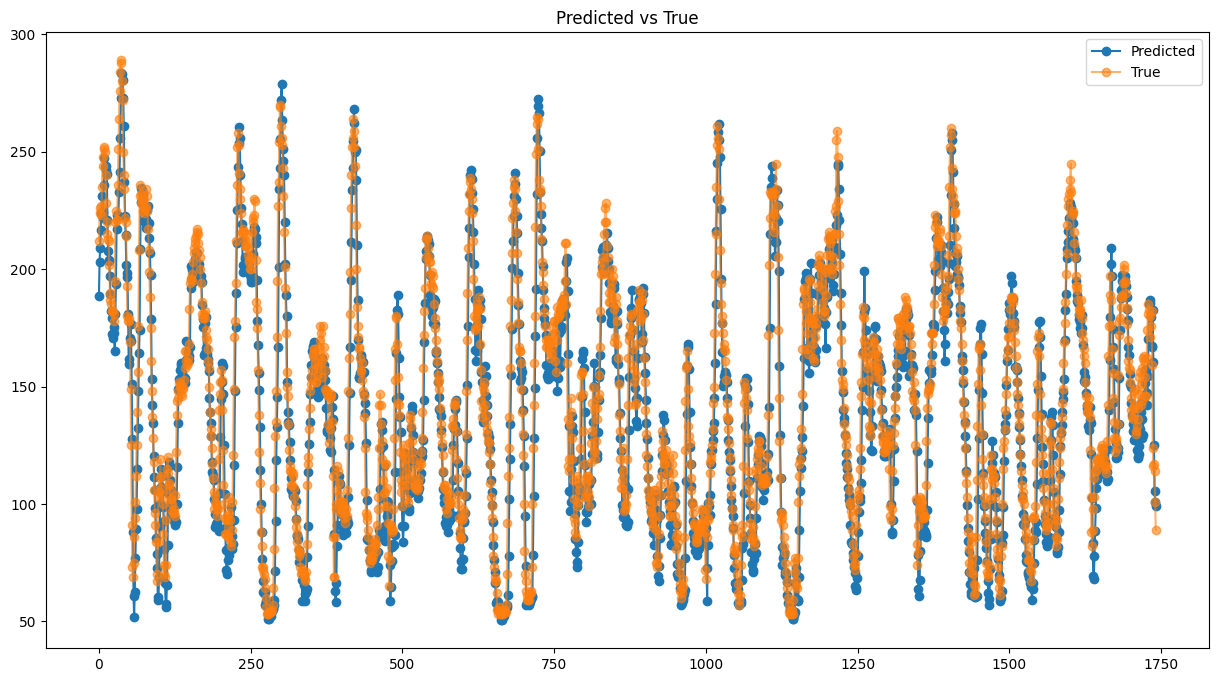

{'mae': 12.726041659367208,
 'mse': 17.443938526973493,
 'rmse': 304.29099133283023}

In [33]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [34]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0             212.0
1             224.0
2             226.0
3             227.0
4             223.0
...             ...
1737          116.0
1738          117.0
1739          114.0
1740          101.0
1741           89.0

[1742 rows x 1 columns]

In [35]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   212.0  188.619431
2023-01-01 00:15:00   224.0  202.950089
2023-01-01 00:30:00   226.0  209.007614
2023-01-01 00:45:00   227.0  216.782211
2023-01-01 01:00:00   223.0  224.132401
...                     ...         ...
2023-01-19 02:15:00   116.0  160.556122
2023-01-19 02:30:00   117.0  125.244652
2023-01-19 02:45:00   114.0  105.473351
2023-01-19 03:00:00   101.0  100.754814
2023-01-19 03:15:00    89.0   99.194313

[1742 rows x 2 columns]

AP, BE, EP: (0.9862148190695003, 0.00861573808156232, 0.005169442848937392)


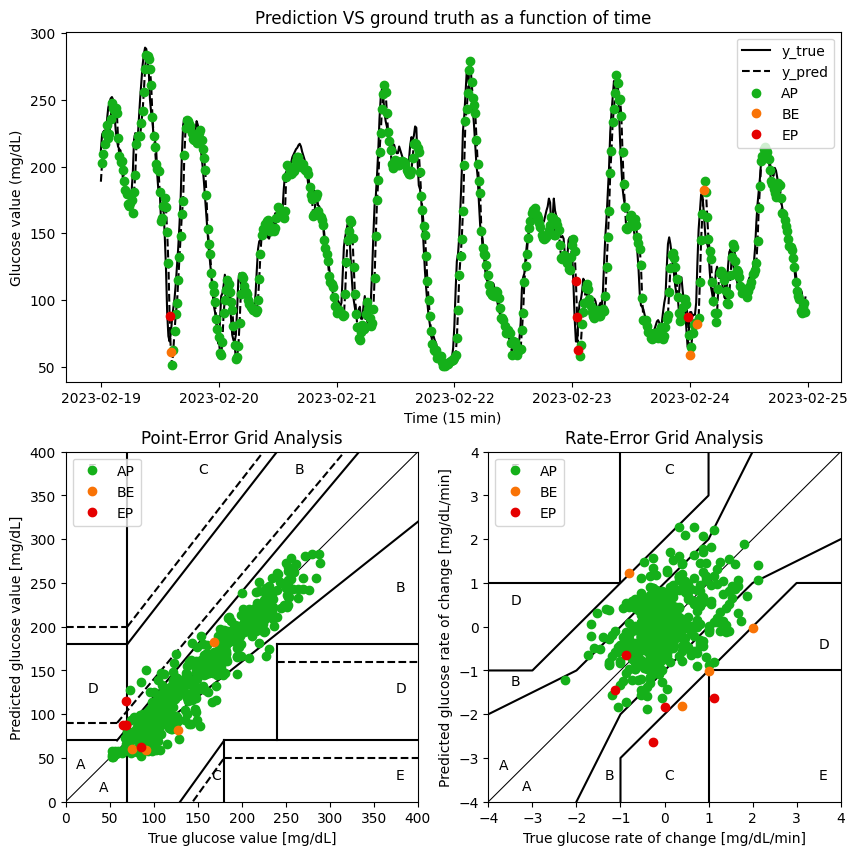

In [36]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [37]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0    2023-02-19 00:00:00   212.0  188.619431       NaN       NaN    NaN   NaN   
1    2023-02-19 00:15:00   224.0  202.950089  0.800000  0.955377     AP     A   
2    2023-02-19 00:30:00   226.0  209.007614  0.133333  0.403835     AP     A   
3    2023-02-19 00:45:00   227.0  216.782211  0.066667  0.518306     AP     A   
4    2023-02-19 01:00:00   223.0  224.132401 -0.266667  0.490013     AP     A   
...                  ...     ...         ...       ...       ...    ...   ...   
1737 2023-03-09 02:15:00   116.0  160.556122 -0.533333 -1.468855     AP     B   
1738 2023-03-09 02:30:00   117.0  125.244652  0.066667 -2.354098     BE     A   
1739 2023-03-09 02:45:00   114.0  105.473351 -0.200000 -1.318087     AP     A   
1740 2023-03-09 03:00:00   101.0  100.754814 -0.866667 -0.314569     AP     A   
1741 2023-03-09 03:15:00    89.0   99.194313 -0.800000 -0.104033     AP     A   

     R_EGA  
0      NaN  
1        A  
2        A  
3        A  
4        A  
...    ...  
1737     A  
1738    lC  
1739     B  
1740     A  
1741     A  

[1742 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [38]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [39]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 51ms/step


Glucose level Predict  Glucose level True
0               0.323086            0.373913
1               0.354239            0.400000

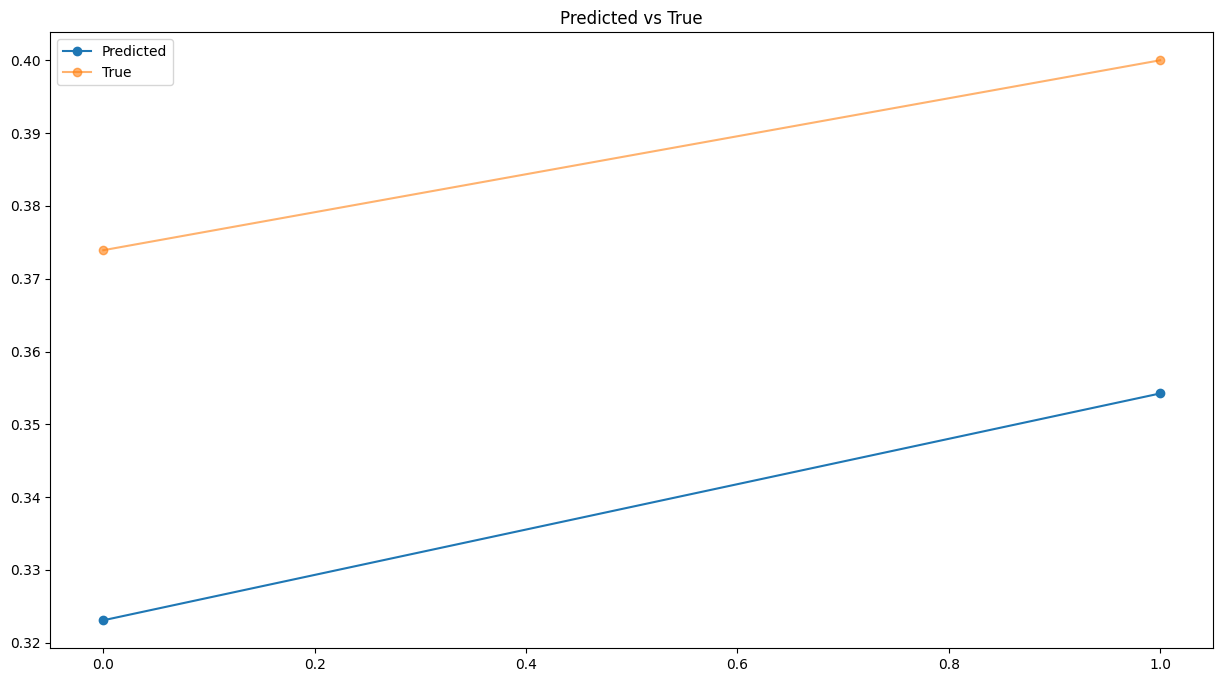

{'mae': 0.048294031490450334,
 'mse': 0.04836042979546364,
 'rmse': 0.0023387311700019675}

In [40]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [41]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             188.619431               212.0
1             202.950073               224.0

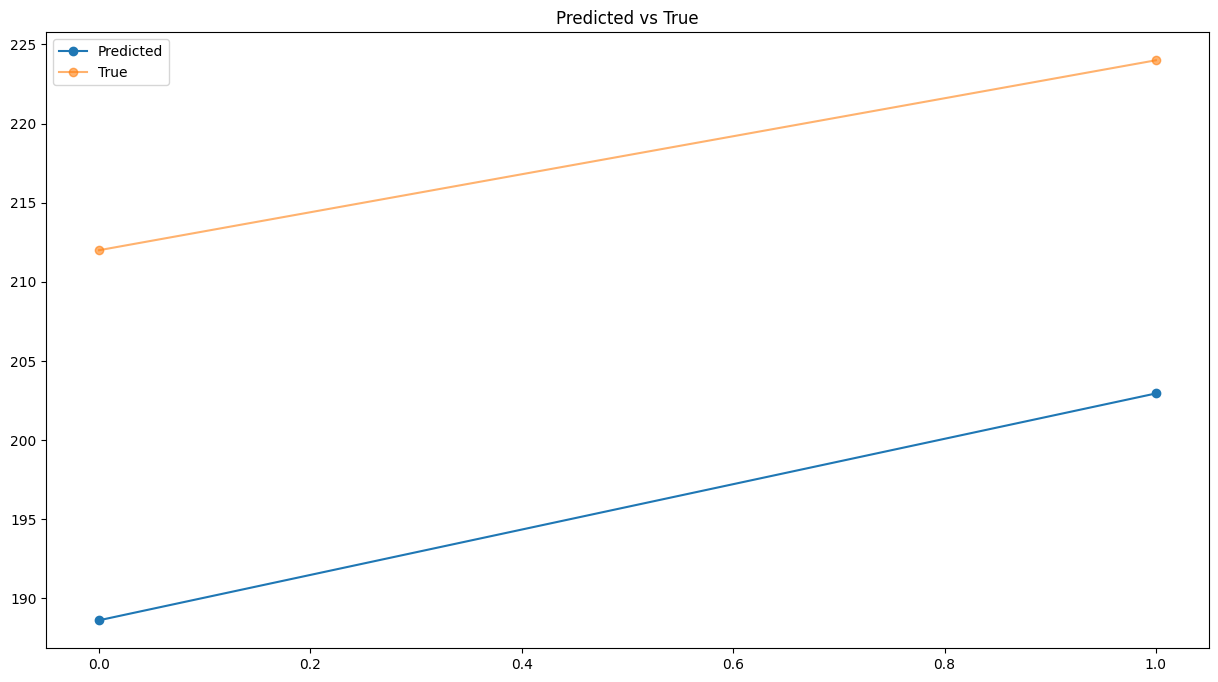

{'mae': 22.215248107910156,
 'mse': 22.245791115287386,
 'rmse': 494.8752223449992}

In [42]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Stacked LSTM con dropout

In [43]:
model = keras.models.load_model('modelos/'+paciente+'/stacked_dropout_balanceado.h5')

# Predicción de todo el conjunto de pruebas generales

In [44]:
len(array_Ytest)

1742

55/55 [==============================] - 2s 16ms/step


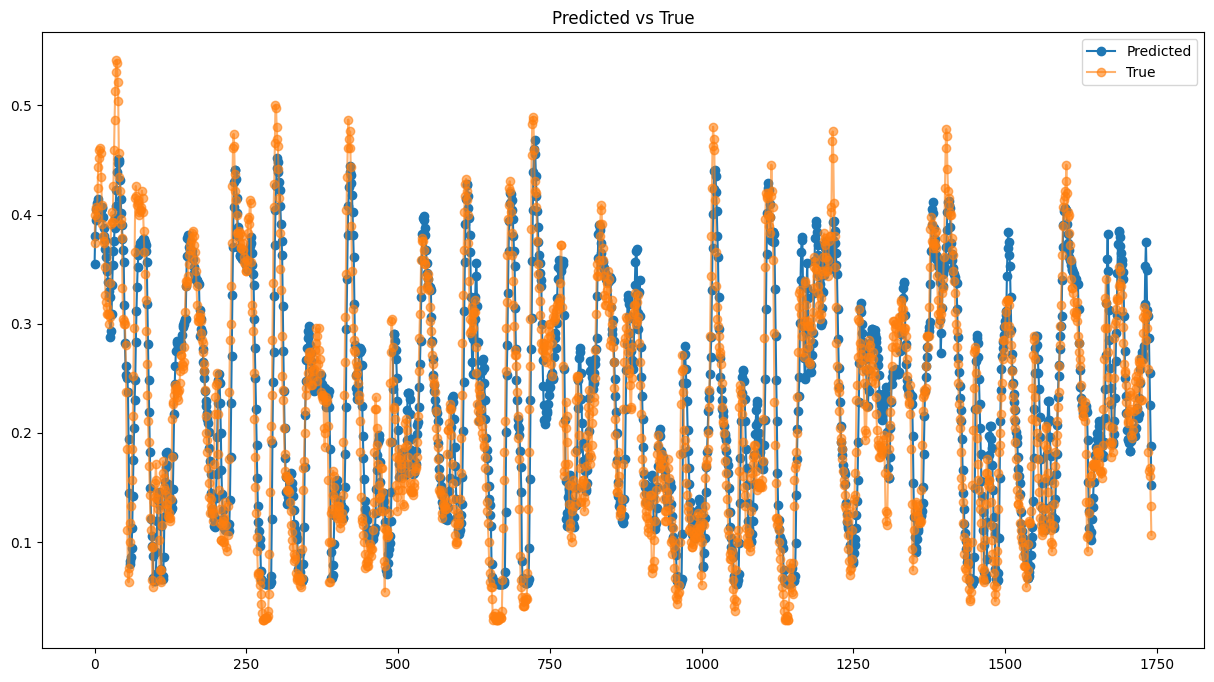

In [45]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [46]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.040163709044955594,
 'mse': 0.0519910943424051,
 'rmse': 0.0027030738909208673}

In [47]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        203.096222
1        214.838257
2        221.886932
3        226.305527
4        228.756653
...             ...
1737     172.018326
1738     157.209900
1739     143.580841
1740     126.370071
1741     109.922882

[1742 rows x 1 columns]

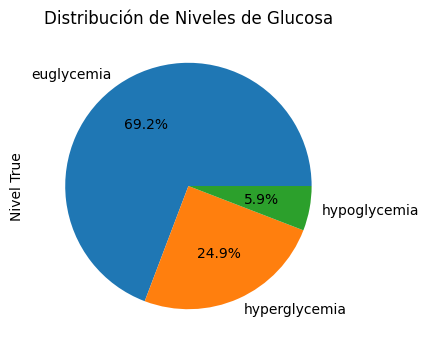

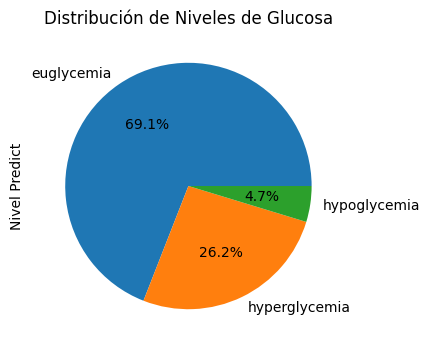

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               212.0  hyperglycemia             203.096222  hyperglycemia
1               224.0  hyperglycemia             214.838257  hyperglycemia
2               226.0  hyperglycemia             221.886932  hyperglycemia
3               227.0  hyperglycemia             226.305527  hyperglycemia
4               223.0  hyperglycemia             228.756653  hyperglycemia

In [48]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


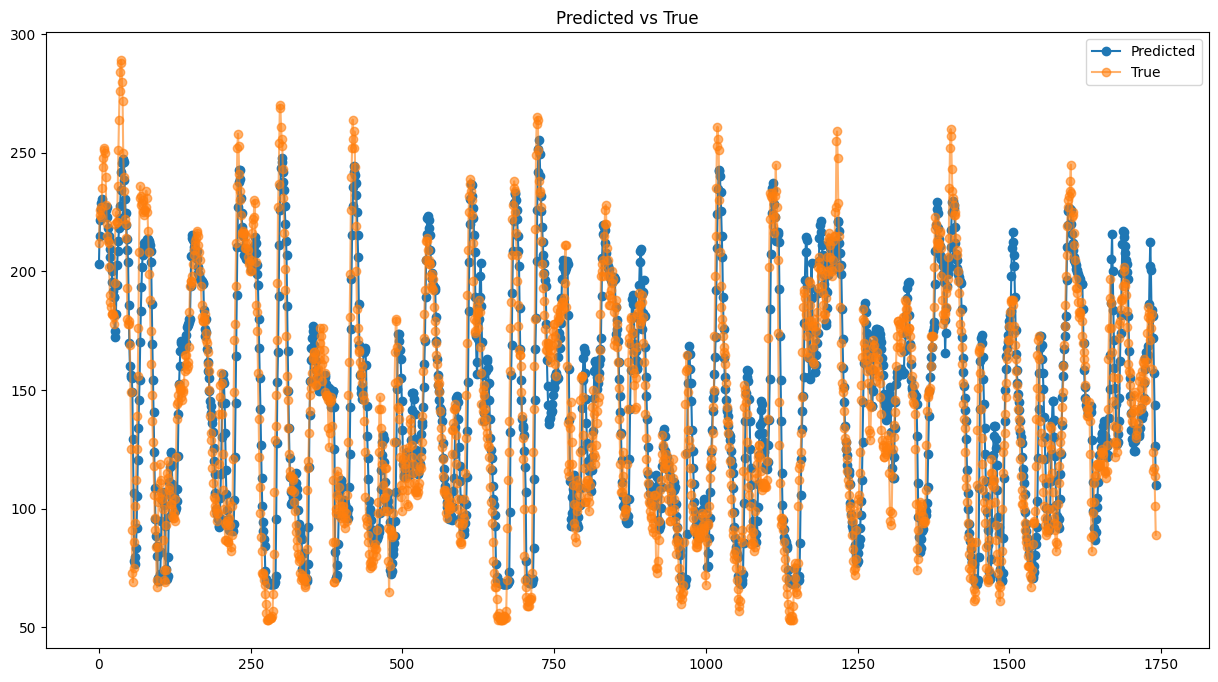

{'mae': 18.47530636092141,
 'mse': 23.915903787143126,
 'rmse': 571.9704539558869}

In [49]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [50]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0             212.0
1             224.0
2             226.0
3             227.0
4             223.0
...             ...
1737          116.0
1738          117.0
1739          114.0
1740          101.0
1741           89.0

[1742 rows x 1 columns]

In [51]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   212.0  203.096222
2023-01-01 00:15:00   224.0  214.838257
2023-01-01 00:30:00   226.0  221.886932
2023-01-01 00:45:00   227.0  226.305527
2023-01-01 01:00:00   223.0  228.756653
...                     ...         ...
2023-01-19 02:15:00   116.0  172.018326
2023-01-19 02:30:00   117.0  157.209900
2023-01-19 02:45:00   114.0  143.580841
2023-01-19 03:00:00   101.0  126.370071
2023-01-19 03:15:00    89.0  109.922882

[1742 rows x 2 columns]

AP, BE, EP: (0.974152785755313, 0.009190120620333142, 0.01665709362435382)


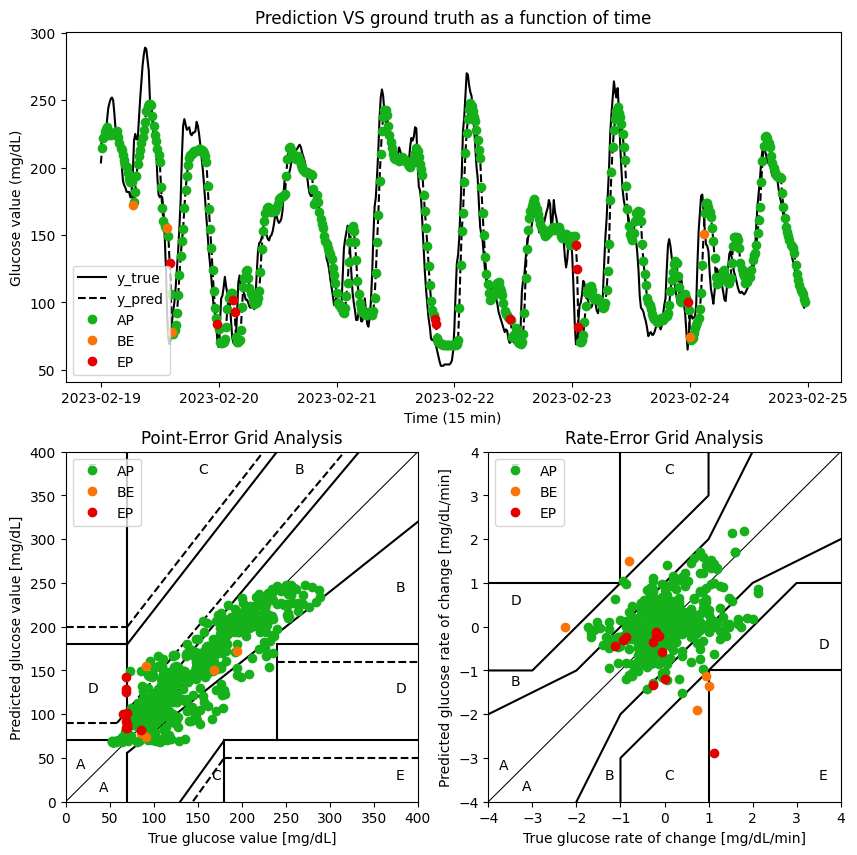

In [52]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [53]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0    2023-02-19 00:00:00   212.0  203.096222       NaN       NaN    NaN   NaN   
1    2023-02-19 00:15:00   224.0  214.838257  0.800000  0.782802     AP     A   
2    2023-02-19 00:30:00   226.0  221.886932  0.133333  0.469912     AP     A   
3    2023-02-19 00:45:00   227.0  226.305527  0.066667  0.294573     AP     A   
4    2023-02-19 01:00:00   223.0  228.756653 -0.266667  0.163408     AP     A   
...                  ...     ...         ...       ...       ...    ...   ...   
1737 2023-03-09 02:15:00   116.0  172.018326 -0.533333 -0.615644     AP     B   
1738 2023-03-09 02:30:00   117.0  157.209900  0.066667 -0.987228     AP     B   
1739 2023-03-09 02:45:00   114.0  143.580841 -0.200000 -0.908604     AP     B   
1740 2023-03-09 03:00:00   101.0  126.370071 -0.866667 -1.147385     AP     B   
1741 2023-03-09 03:15:00    89.0  109.922882 -0.800000 -1.096479     AP     B   

     R_EGA  
0      NaN  
1        A  
2        A  
3        A  
4        A  
...    ...  
1737     A  
1738     B  
1739     A  
1740     A  
1741     A  

[1742 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [54]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [55]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 30ms/step


Glucose level Predict  Glucose level True
0               0.354557            0.373913
1               0.380083            0.400000

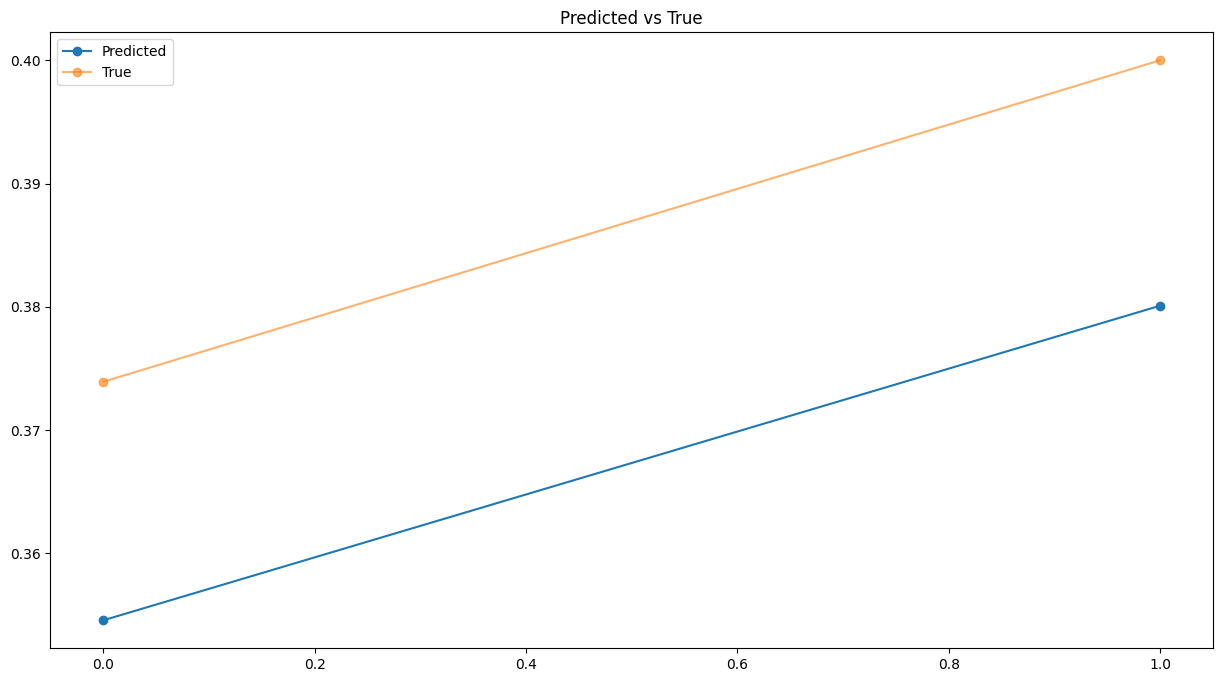

{'mae': 0.019636431206827593,
 'mse': 0.01963843303457239,
 'rmse': 0.0003856680520533842}

In [56]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [57]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             203.096222               212.0
1             214.838257               224.0

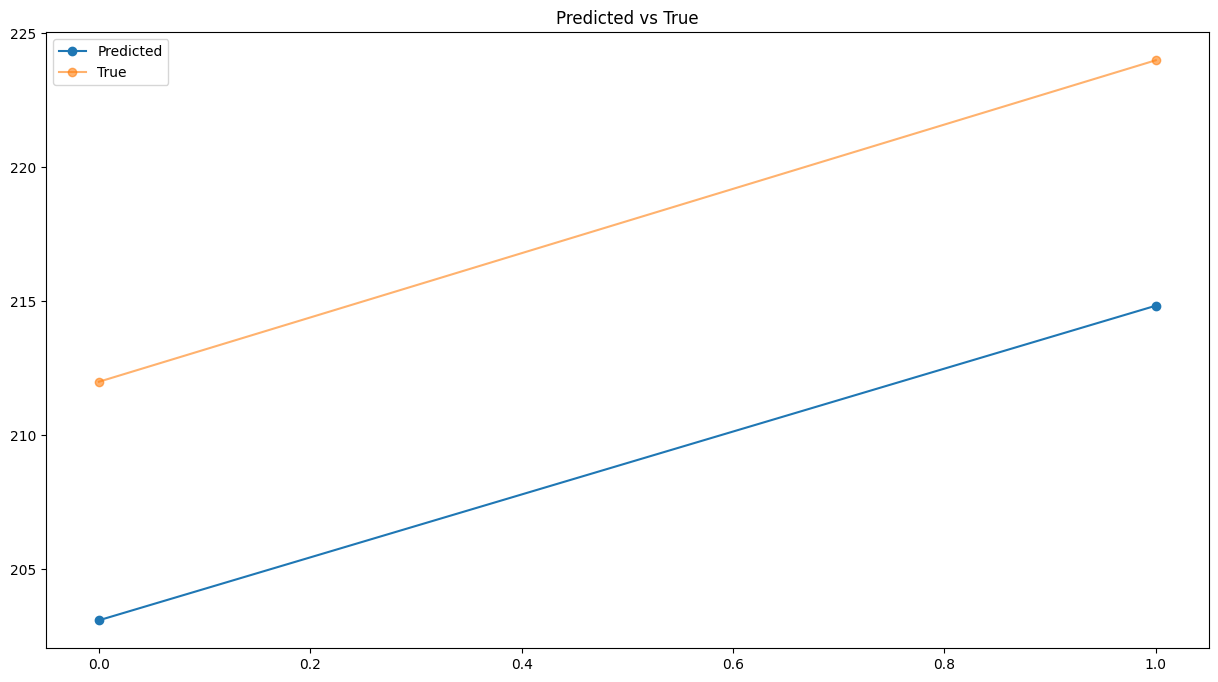

{'mae': 9.032760620117188, 'mse': 9.033681470861282, 'rmse': 81.60740091698244}

In [58]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Stacked LSTM sin dropout

In [59]:
model = keras.models.load_model('modelos/'+paciente+'/stacked_NO_dropout_balanceado.h5')

# Predicción de todo el conjunto de pruebas generales

In [60]:
len(array_Ytest)

1742

55/55 [==============================] - 2s 16ms/step


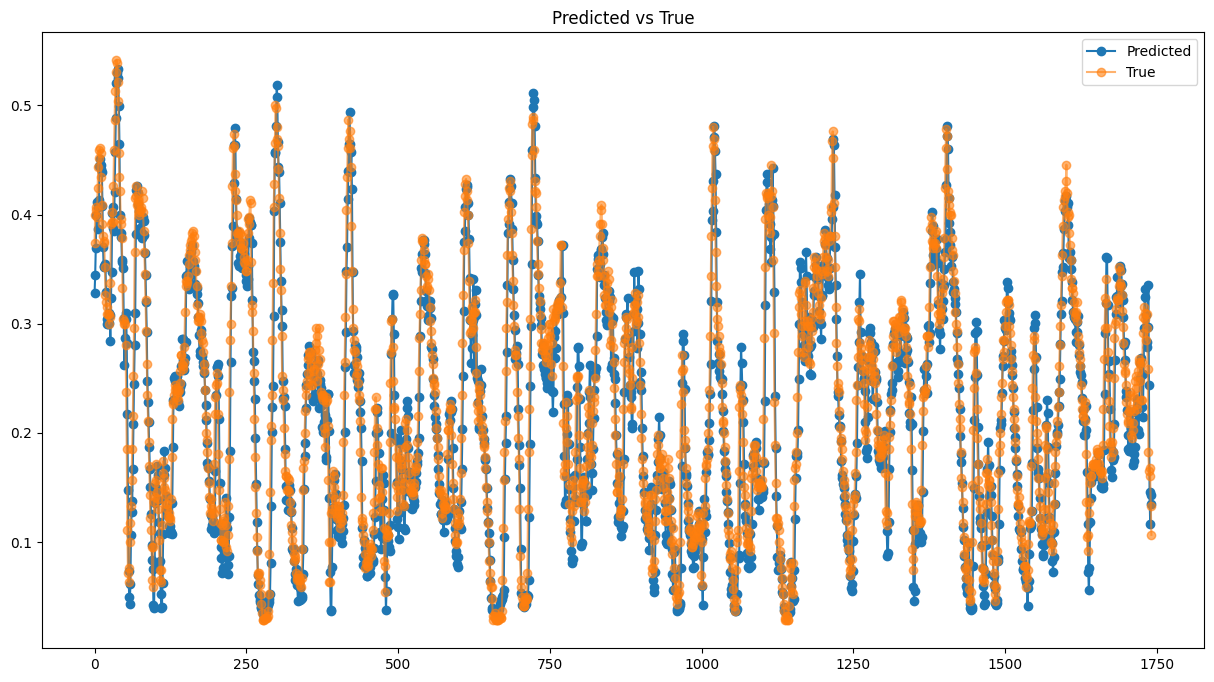

In [61]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [62]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.02500001381920174,
 'mse': 0.03436008299009863,
 'rmse': 0.0011806153030864653}

In [63]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        190.862534
1        198.341873
2        209.849991
3        223.908752
4        229.066208
...             ...
1737     152.219955
1738     107.268280
1739      93.779213
1740     102.165070
1741     105.854210

[1742 rows x 1 columns]

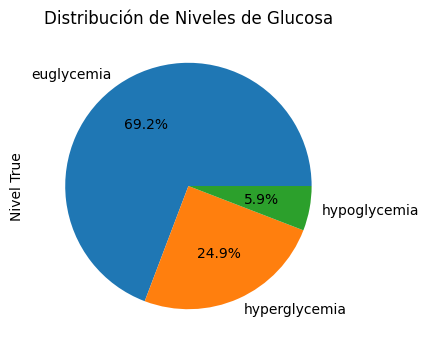

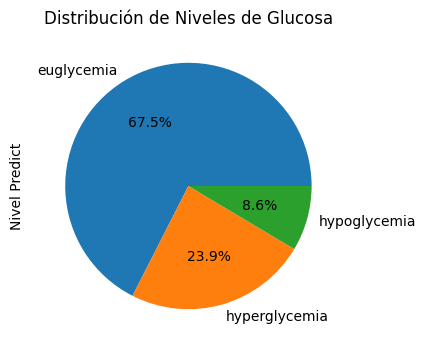

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               212.0  hyperglycemia             190.862534  hyperglycemia
1               224.0  hyperglycemia             198.341873  hyperglycemia
2               226.0  hyperglycemia             209.849991  hyperglycemia
3               227.0  hyperglycemia             223.908752  hyperglycemia
4               223.0  hyperglycemia             229.066208  hyperglycemia

In [64]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


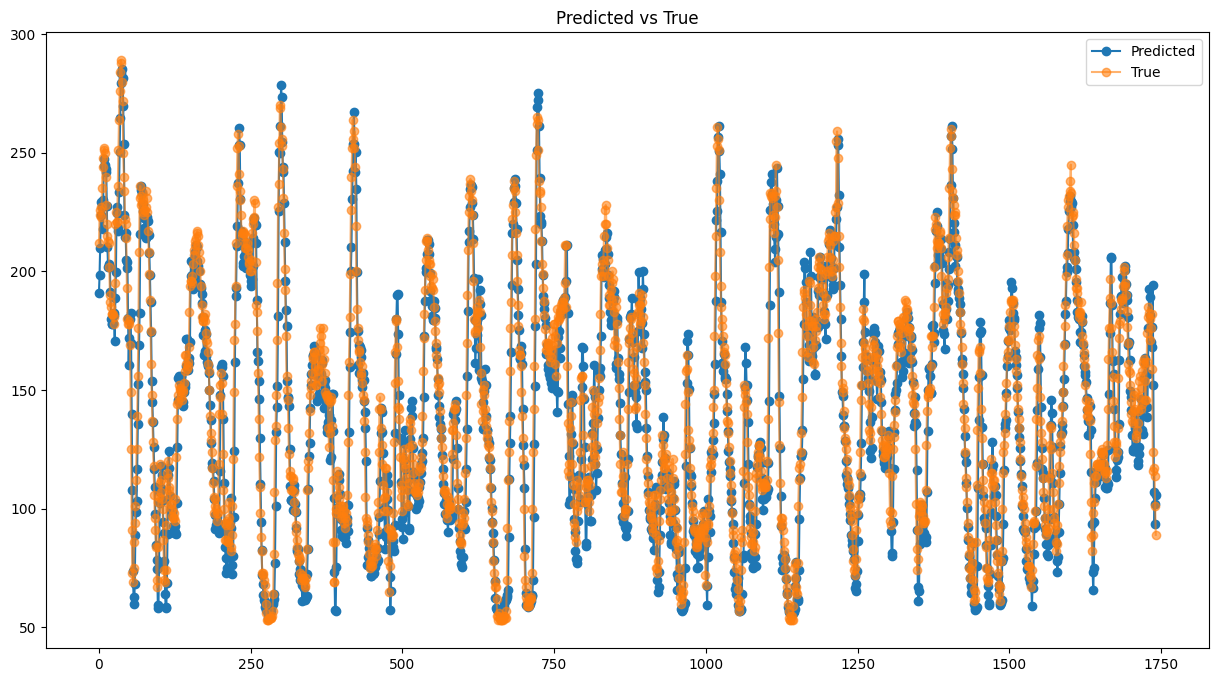

{'mae': 11.500006559439832,
 'mse': 15.805638390408376,
 'rmse': 249.8182049283511}

In [65]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [66]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0             212.0
1             224.0
2             226.0
3             227.0
4             223.0
...             ...
1737          116.0
1738          117.0
1739          114.0
1740          101.0
1741           89.0

[1742 rows x 1 columns]

In [67]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   212.0  190.862534
2023-01-01 00:15:00   224.0  198.341873
2023-01-01 00:30:00   226.0  209.849991
2023-01-01 00:45:00   227.0  223.908752
2023-01-01 01:00:00   223.0  229.066208
...                     ...         ...
2023-01-19 02:15:00   116.0  152.219955
2023-01-19 02:30:00   117.0  107.268280
2023-01-19 02:45:00   114.0   93.779213
2023-01-19 03:00:00   101.0  102.165070
2023-01-19 03:15:00    89.0  105.854210

[1742 rows x 2 columns]

AP, BE, EP: (0.9833429063756461, 0.010913268236645606, 0.005743825387708214)


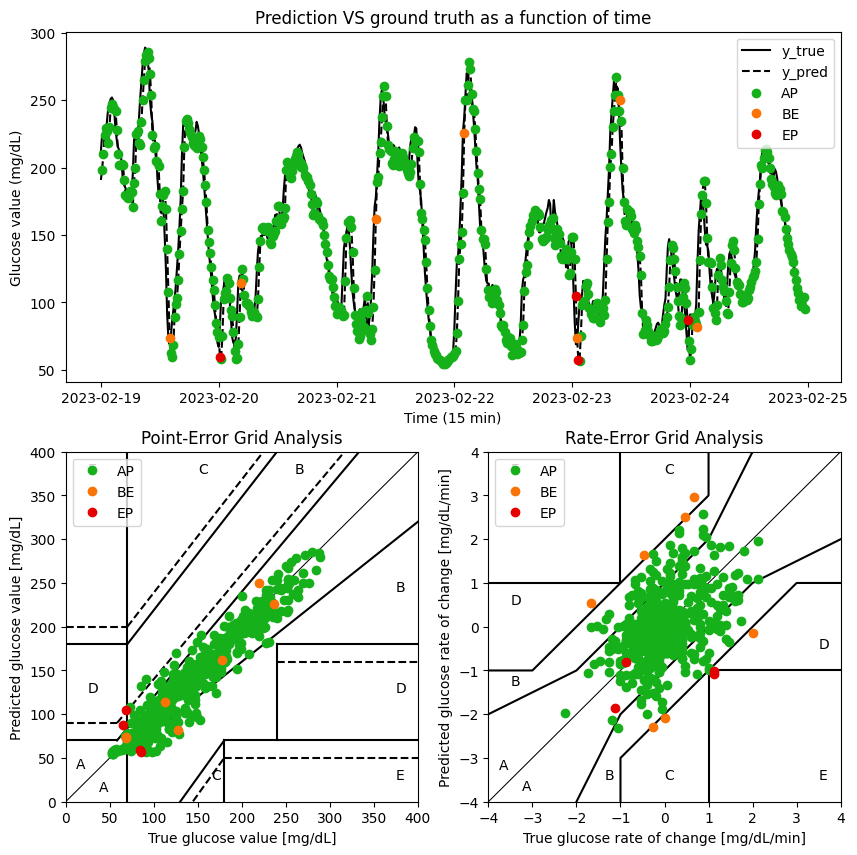

In [68]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [69]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0    2023-02-19 00:00:00   212.0  190.862534       NaN       NaN    NaN   NaN   
1    2023-02-19 00:15:00   224.0  198.341873  0.800000  0.498623     AP     A   
2    2023-02-19 00:30:00   226.0  209.849991  0.133333  0.767208     AP     A   
3    2023-02-19 00:45:00   227.0  223.908752  0.066667  0.937251     AP     A   
4    2023-02-19 01:00:00   223.0  229.066208 -0.266667  0.343830     AP     A   
...                  ...     ...         ...       ...       ...    ...   ...   
1737 2023-03-09 02:15:00   116.0  152.219955 -0.533333 -2.793593     BE     B   
1738 2023-03-09 02:30:00   117.0  107.268280  0.066667 -2.996778     BE     A   
1739 2023-03-09 02:45:00   114.0   93.779213 -0.200000 -0.899271     AP     A   
1740 2023-03-09 03:00:00   101.0  102.165070 -0.866667  0.559057     AP     A   
1741 2023-03-09 03:15:00    89.0  105.854210 -0.800000  0.245943     AP     A   

     R_EGA  
0      NaN  
1        A  
2        A  
3        A  
4        A  
...    ...  
1737    lC  
1738    lC  
1739     A  
1740     B  
1741     B  

[1742 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [70]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [71]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 53ms/step


Glucose level Predict  Glucose level True
0               0.327962            0.373913
1               0.344221            0.400000

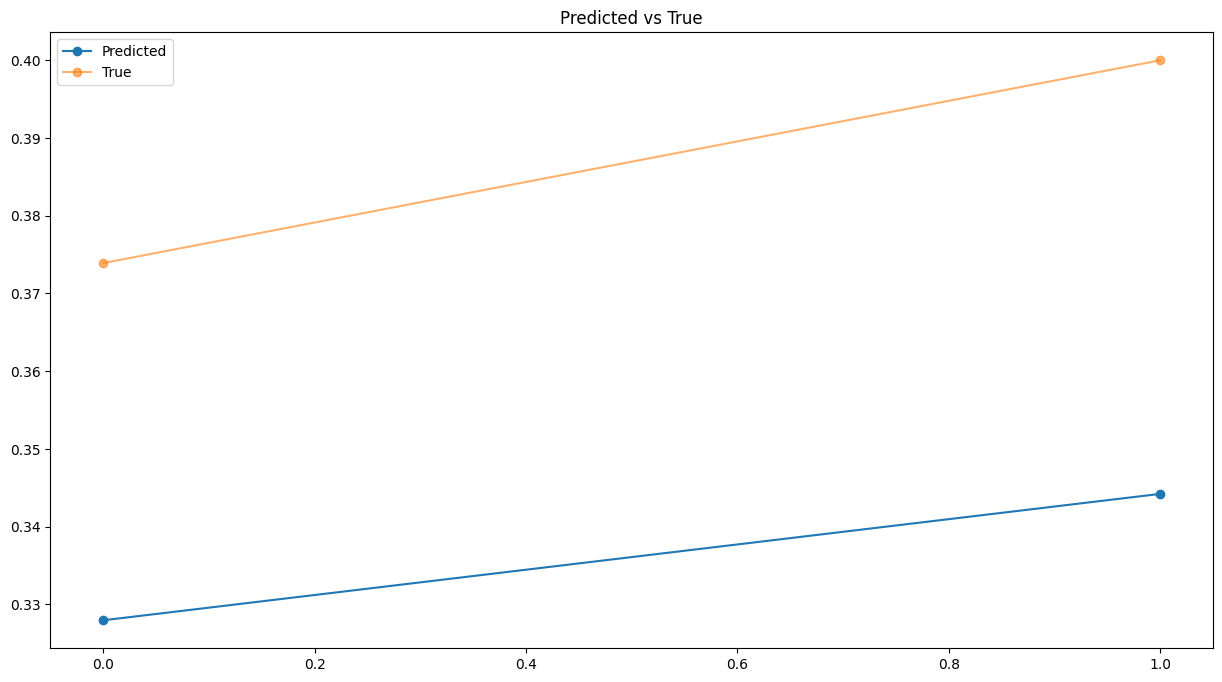

{'mae': 0.050864794720774126,
 'mse': 0.05110158903922662,
 'rmse': 0.002611372402334006}

In [72]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [73]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             190.862534               212.0
1             198.341873               224.0

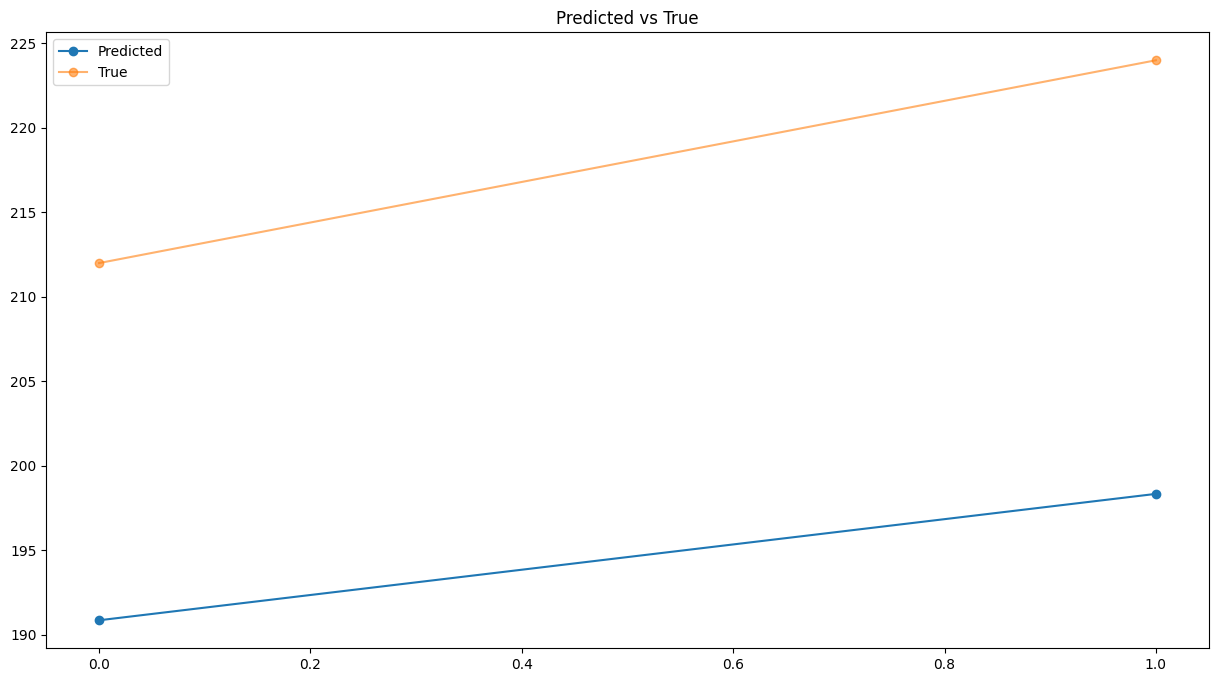

{'mae': 23.397796630859375,
 'mse': 23.506722012925778,
 'rmse': 552.5659797929693}

In [74]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Bidirectional LSTM con dropout

In [75]:
model = keras.models.load_model('modelos/'+paciente+'/bidirectional_dropout_balanceado.h5')

# Predicción de todo el conjunto de pruebas generales

In [76]:
len(array_Ytest)

1742

55/55 [==============================] - 1s 5ms/step


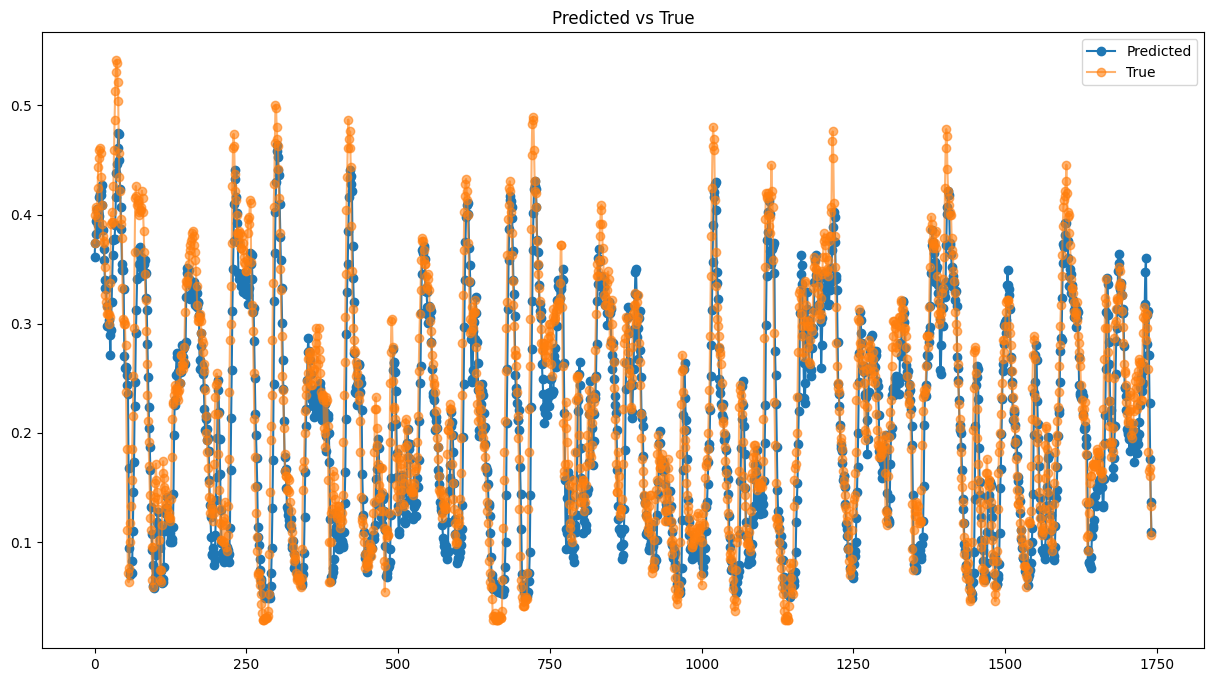

In [77]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [78]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.03737389501812576,
 'mse': 0.05047102902637739,
 'rmse': 0.0025473247709814286}

In [79]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        205.886230
1        211.920746
2        215.770935
3        221.177917
4        226.327835
...             ...
1737     164.721512
1738     144.585983
1739     120.970558
1740     102.978485
1741      90.021309

[1742 rows x 1 columns]

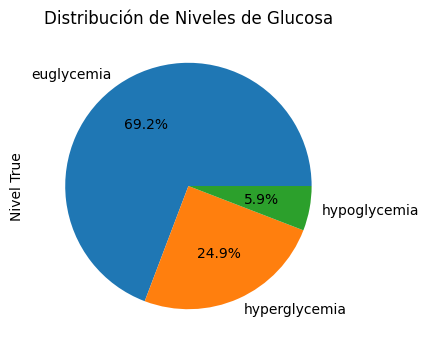

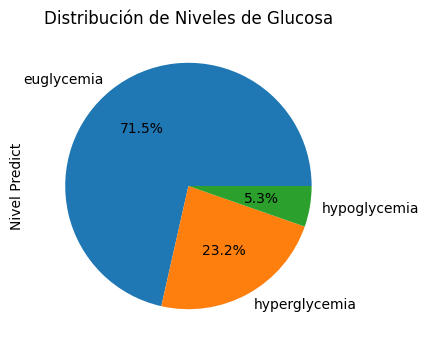

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               212.0  hyperglycemia             205.886230  hyperglycemia
1               224.0  hyperglycemia             211.920746  hyperglycemia
2               226.0  hyperglycemia             215.770935  hyperglycemia
3               227.0  hyperglycemia             221.177917  hyperglycemia
4               223.0  hyperglycemia             226.327835  hyperglycemia

In [80]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


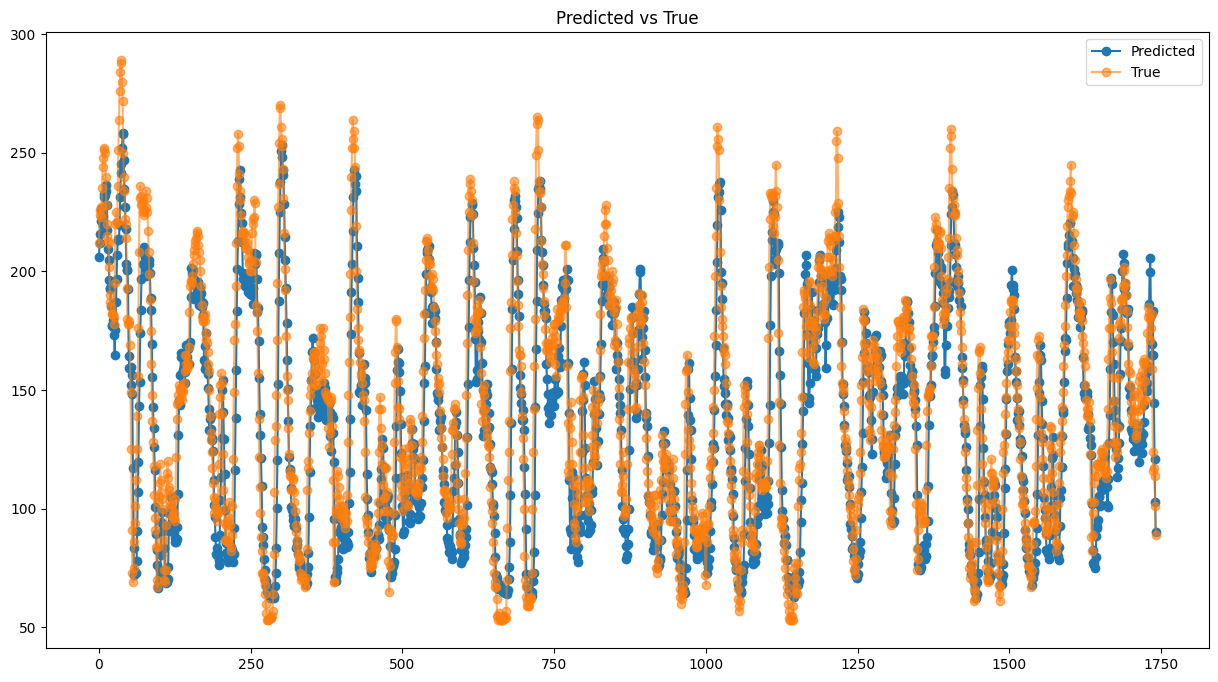

{'mae': 17.19199153755617,
 'mse': 23.216673189057918,
 'rmse': 539.0139139675208}

In [81]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [82]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0             212.0
1             224.0
2             226.0
3             227.0
4             223.0
...             ...
1737          116.0
1738          117.0
1739          114.0
1740          101.0
1741           89.0

[1742 rows x 1 columns]

In [83]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   212.0  205.886230
2023-01-01 00:15:00   224.0  211.920746
2023-01-01 00:30:00   226.0  215.770935
2023-01-01 00:45:00   227.0  221.177917
2023-01-01 01:00:00   223.0  226.327835
...                     ...         ...
2023-01-19 02:15:00   116.0  164.721512
2023-01-19 02:30:00   117.0  144.585983
2023-01-19 02:45:00   114.0  120.970558
2023-01-19 03:00:00   101.0  102.978485
2023-01-19 03:15:00    89.0   90.021309

[1742 rows x 2 columns]

AP, BE, EP: (0.9844916714531878, 0.0080413555427915, 0.007466973004020678)


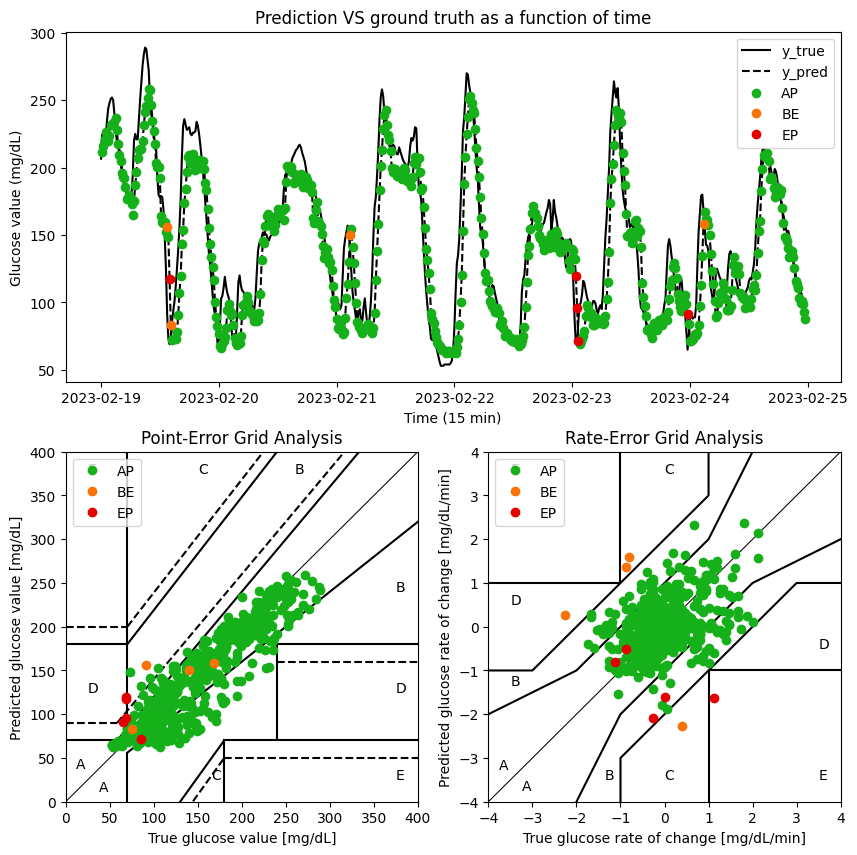

In [84]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [85]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0    2023-02-19 00:00:00   212.0  205.886230       NaN       NaN    NaN   NaN   
1    2023-02-19 00:15:00   224.0  211.920746  0.800000  0.402301     AP     A   
2    2023-02-19 00:30:00   226.0  215.770935  0.133333  0.256679     AP     A   
3    2023-02-19 00:45:00   227.0  221.177917  0.066667  0.360465     AP     A   
4    2023-02-19 01:00:00   223.0  226.327835 -0.266667  0.343328     AP     A   
...                  ...     ...         ...       ...       ...    ...   ...   
1737 2023-03-09 02:15:00   116.0  164.721512 -0.533333 -1.242963     AP     B   
1738 2023-03-09 02:30:00   117.0  144.585983  0.066667 -1.342369     AP     B   
1739 2023-03-09 02:45:00   114.0  120.970558 -0.200000 -1.574362     AP     A   
1740 2023-03-09 03:00:00   101.0  102.978485 -0.866667 -1.199472     AP     A   
1741 2023-03-09 03:15:00    89.0   90.021309 -0.800000 -0.863812     AP     A   

     R_EGA  
0      NaN  
1        A  
2        A  
3        A  
4        A  
...    ...  
1737     A  
1738     B  
1739     B  
1740     A  
1741     A  

[1742 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [86]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [87]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 48ms/step


Glucose level Predict  Glucose level True
0               0.360622            0.373913
1               0.373741            0.400000

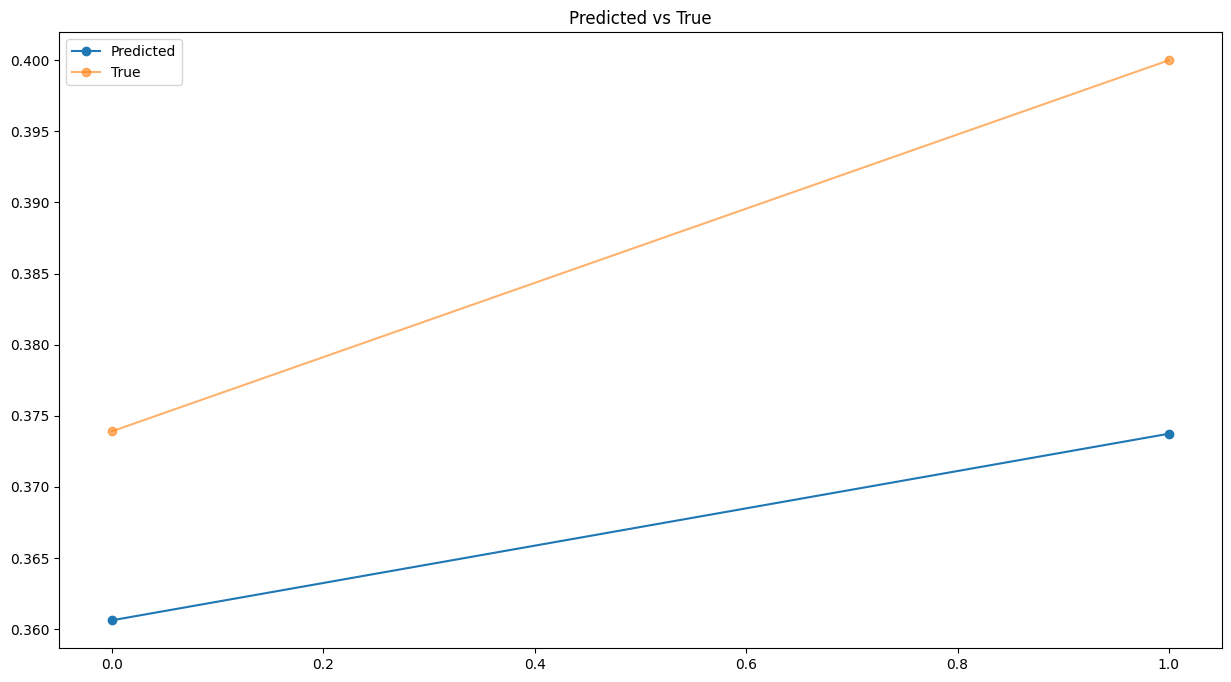

{'mae': 0.01977507161057515,
 'mse': 0.020811022027340566,
 'rmse': 0.0004330986378224543}

In [88]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [89]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             205.886215               212.0
1             211.920731               224.0

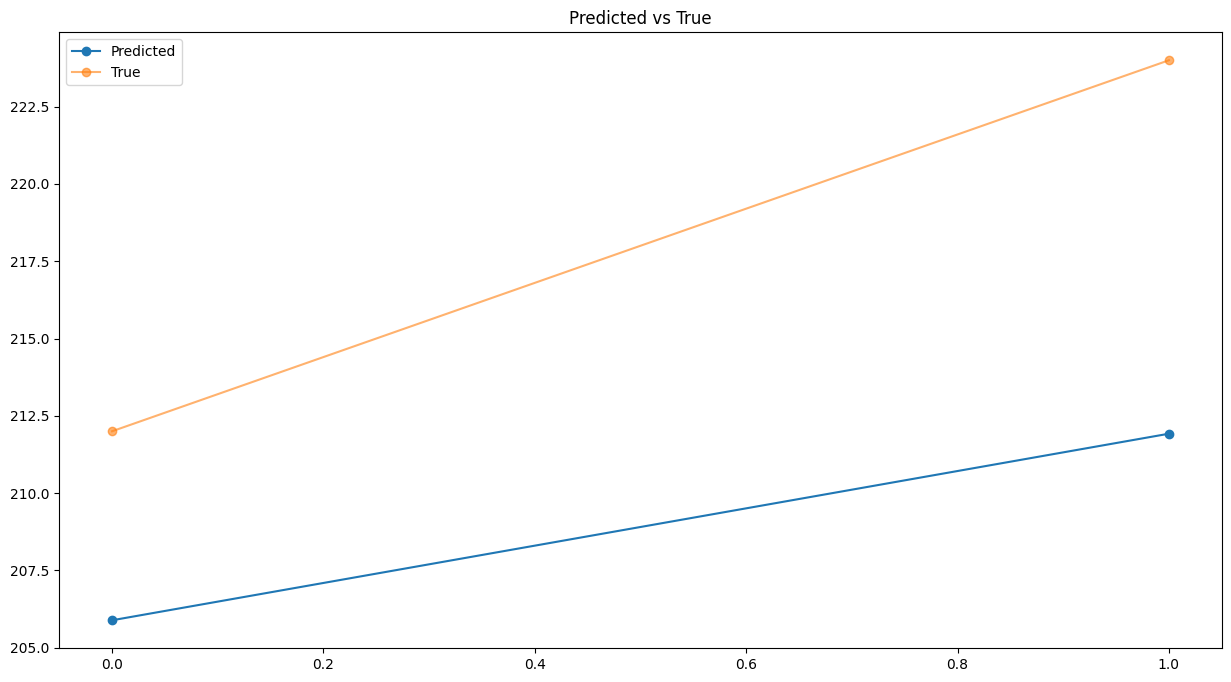

{'mae': 9.096527099609375, 'mse': 9.573064136379145, 'rmse': 91.64355695922859}

In [90]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Bidirectional LSTM sin dropout

In [91]:
model = keras.models.load_model('modelos/'+paciente+'/bidirectional_NO_dropout_balanceado.h5')

# Predicción de todo el conjunto de pruebas generales

In [92]:
len(array_Ytest)

1742

55/55 [==============================] - 1s 8ms/step


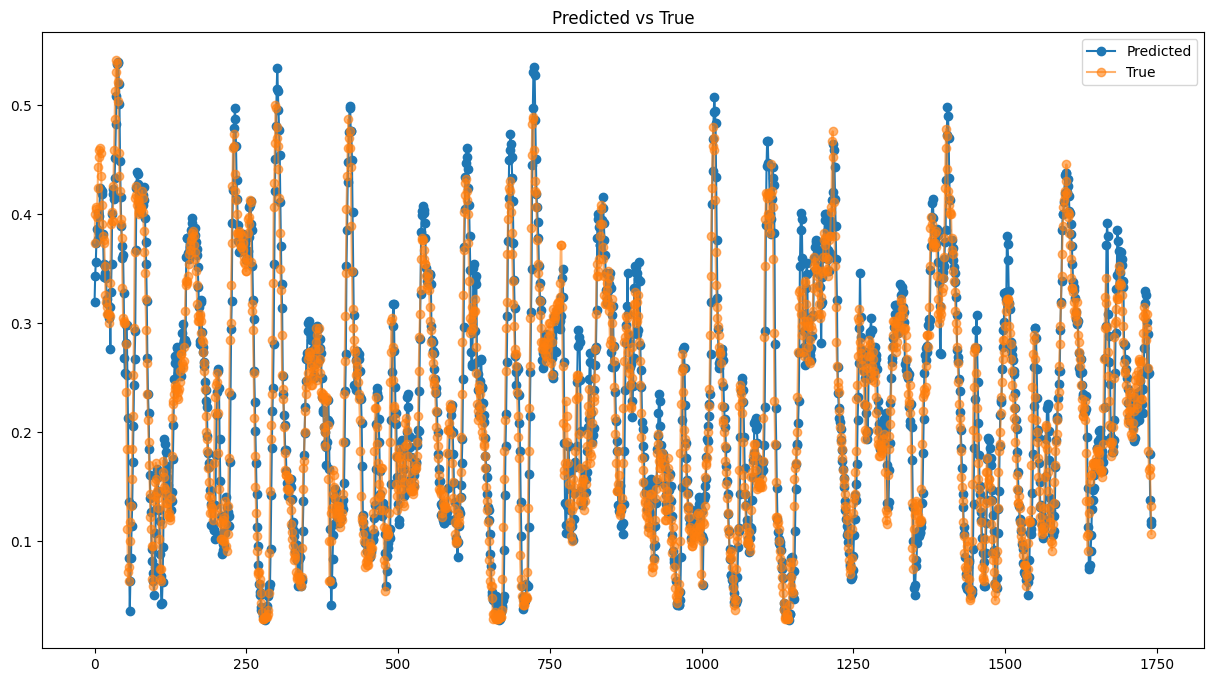

In [93]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [94]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.03007004220033632,
 'mse': 0.039467523780369614,
 'rmse': 0.0015576854333540409}

In [95]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        187.051941
1        197.929214
2        203.651352
3        211.947159
4        217.650421
...             ...
1737     156.767563
1738     122.723549
1739     103.223495
1740      94.507156
1741      93.086060

[1742 rows x 1 columns]

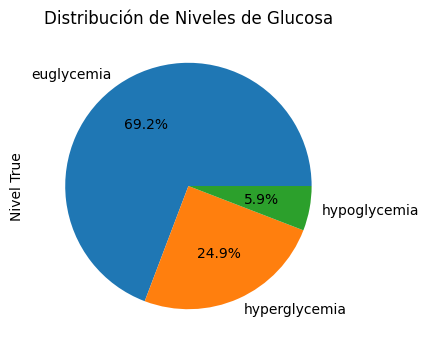

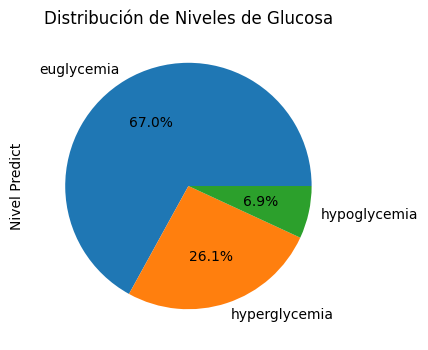

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               212.0  hyperglycemia             187.051941  hyperglycemia
1               224.0  hyperglycemia             197.929214  hyperglycemia
2               226.0  hyperglycemia             203.651352  hyperglycemia
3               227.0  hyperglycemia             211.947159  hyperglycemia
4               223.0  hyperglycemia             217.650421  hyperglycemia

In [96]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


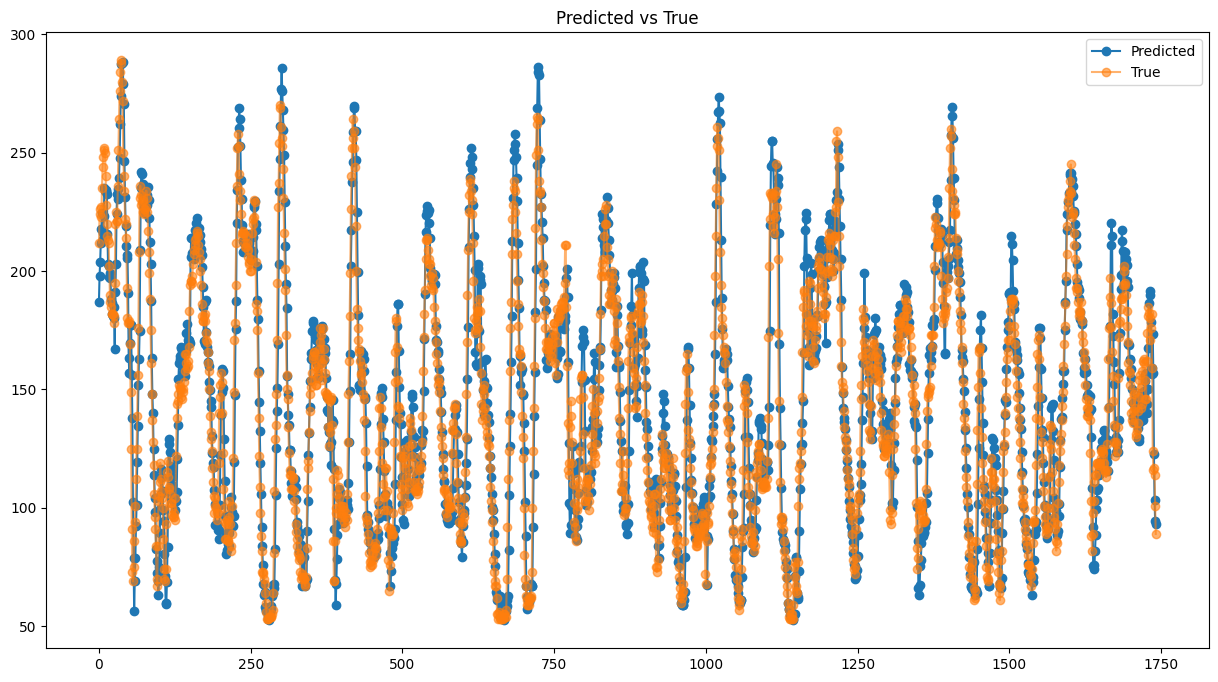

{'mae': 13.832219573851978, 'mse': 18.15506111448251, 'rmse': 329.606244070595}

In [97]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [98]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0             212.0
1             224.0
2             226.0
3             227.0
4             223.0
...             ...
1737          116.0
1738          117.0
1739          114.0
1740          101.0
1741           89.0

[1742 rows x 1 columns]

In [99]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   212.0  187.051941
2023-01-01 00:15:00   224.0  197.929214
2023-01-01 00:30:00   226.0  203.651352
2023-01-01 00:45:00   227.0  211.947159
2023-01-01 01:00:00   223.0  217.650421
...                     ...         ...
2023-01-19 02:15:00   116.0  156.767563
2023-01-19 02:30:00   117.0  122.723549
2023-01-19 02:45:00   114.0  103.223495
2023-01-19 03:00:00   101.0   94.507156
2023-01-19 03:15:00    89.0   93.086060

[1742 rows x 2 columns]

AP, BE, EP: (0.9753015508328546, 0.01723147616312464, 0.007466973004020678)


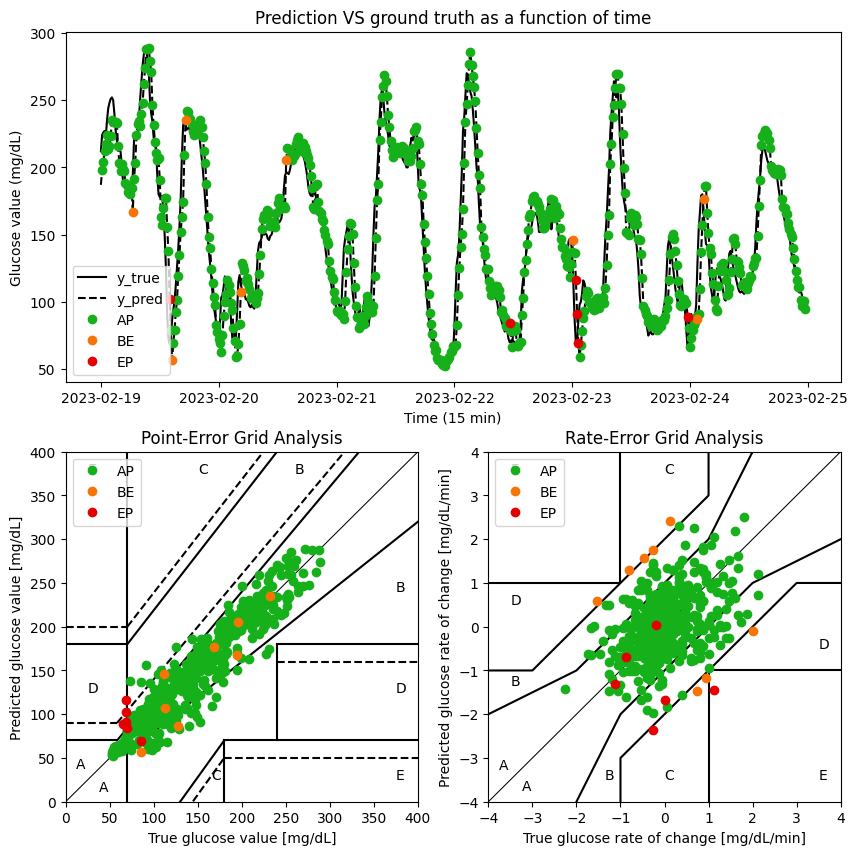

In [100]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [101]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0    2023-02-19 00:00:00   212.0  187.051941       NaN       NaN    NaN   NaN   
1    2023-02-19 00:15:00   224.0  197.929214  0.800000  0.725152     AP     A   
2    2023-02-19 00:30:00   226.0  203.651352  0.133333  0.381476     AP     A   
3    2023-02-19 00:45:00   227.0  211.947159  0.066667  0.553054     AP     A   
4    2023-02-19 01:00:00   223.0  217.650421 -0.266667  0.380217     AP     A   
...                  ...     ...         ...       ...       ...    ...   ...   
1737 2023-03-09 02:15:00   116.0  156.767563 -0.533333 -1.124636     AP     B   
1738 2023-03-09 02:30:00   117.0  122.723549  0.066667 -2.269601     BE     A   
1739 2023-03-09 02:45:00   114.0  103.223495 -0.200000 -1.300004     AP     A   
1740 2023-03-09 03:00:00   101.0   94.507156 -0.866667 -0.581089     AP     A   
1741 2023-03-09 03:15:00    89.0   93.086060 -0.800000 -0.094740     AP     A   

     R_EGA  
0      NaN  
1        A  
2        A  
3        A  
4        A  
...    ...  
1737     A  
1738    lC  
1739     B  
1740     A  
1741     A  

[1742 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [102]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [103]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 51ms/step


Glucose level Predict  Glucose level True
0               0.319678            0.373913
1               0.343324            0.400000

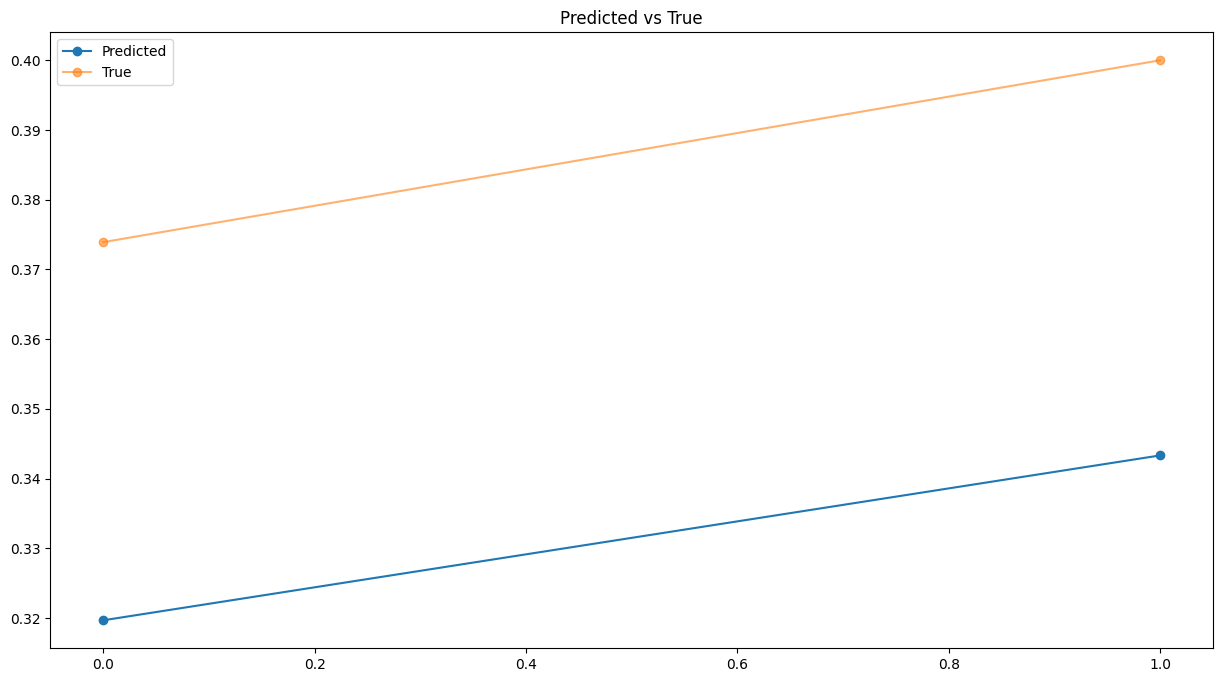

{'mae': 0.055455246438150835,
 'mse': 0.0554686732316004,
 'rmse': 0.0030767737100740626}

In [104]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [105]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             187.051971               212.0
1             197.929214               224.0

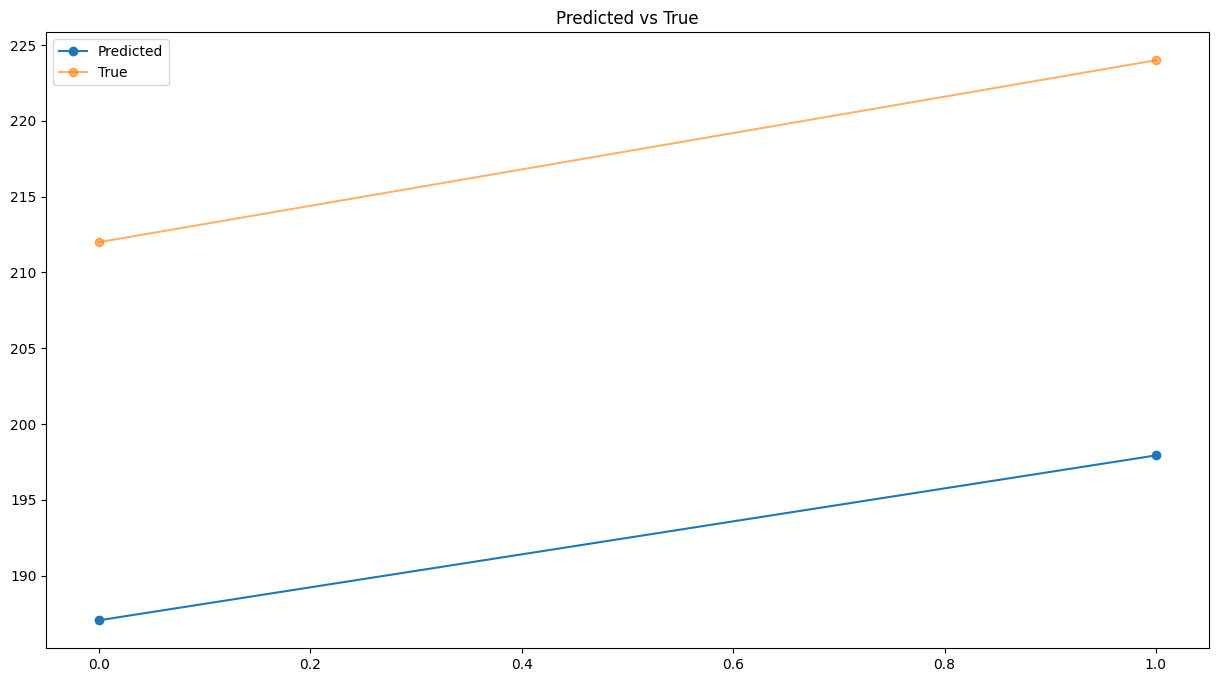

{'mae': 25.50940704345703,
 'mse': 25.515583346368235,
 'rmse': 651.0449935054639}

In [106]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)